# Determinants of Box Office Success

## Imports

In [26]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.stats import iqr

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
movies = pd.read_csv('movie_data.csv')

## Explore and Clean Dataset

**Numeric variables:** num_critic_reviews, duration, director_facebook_likes, actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, movie_facebook_likes, gross, num_users_voted (int), cast_total_facebook_likes  (int), num_user_reviews, budget, title_year , movie_score, aspect_ratio (int)  <br><br>
**Categorical variables:** color, director_name, actor_1_name, actor_2_name, actor_3_name, genres, plot_keywords, language, country, content_rating

In [28]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [29]:
# remove duplicate rows based on the 'movie_title' and 'title_year' column
movies.drop_duplicates(subset=['movie_title','title_year'], keep=False, inplace=True)

# reset index
movies.reset_index(drop=True, inplace=True)

In [30]:
# replace zeros in budget and gross columns with NaN
movies['budget'] = movies['budget'].replace(0, np.NaN)
movies['gross'] = movies['gross'].replace(0,np.NaN)

# transform budget and gross metrics to show in millions
movies['budget_millions'] = round(movies['budget'] / 1000000, 4)
movies['gross_millions'] = round(movies['gross'] / 1000000, 4)

# add calcuated columns
movies['profit_millions'] = movies['gross_millions'] - movies['budget_millions']
movies['roi'] = round((movies['profit_millions'] / movies['budget_millions']), 4)
movies['profit_margin'] = movies['profit_millions'] / movies['gross_millions']

### Remove irrelevant movies
**Challenge** - The dataset contains movies that are not relevant to the move studio's current strategy, including movies from as early as 1916 and non-English language movies.

**Solution** - filter df to exclude all movies released prior to 1996 and all non-English language movies.

In [31]:
# remove all movies from before the year 1996 in order to focus on the most recent data points
movies = movies[movies['title_year']>=1996]

# keep only English language movies
movies = movies[movies['language'] == 'English']

movies.reset_index(drop=True, inplace=True)

### Explore Numeric Variables

**Challenge** - After a preliminary exploration of the numeric variables, it became apparent that several of the numeric variables have significant outliers. The inclusion of outliers will make it more difficult to accurately assess relationships between variables. 

**Solution** - trim numeric variables by replacing outliers with upper whisker values.

**Method** - outliers are identified using the IQR method; replace outliers with upper whisker value; trimmed values are stored in a separate dataframe (movies_trimmed).

In [32]:
# define movies trimmed to hold trimmed variables
movies_trimmed = movies.copy(deep = True)

In [33]:
# separate numerical fields from categorical
movies_numeric = movies.select_dtypes(include=['float64', 'int64'])

# replace outliers with upper whisker / lower whisker value
for column in movies_numeric:
    q1 = movies_trimmed[column].quantile(0.25)
    q3 = movies_trimmed[column].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + (iqr*1.5)
    lower_whisker = q1 - (iqr*1.5)
    movies_trimmed.loc[movies_trimmed[column] > upper_whisker, column] = upper_whisker
    movies_trimmed.loc[movies_trimmed[column] < lower_whisker, column] = lower_whisker

In [34]:
#boxplot = movies_trimmed.boxplot(column=['duration'])
#boxplot = movies_trimmed.boxplot(column=['movie_score'])
#boxplot = movies_trimmed.boxplot(column=['num_critic_reviews'])

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


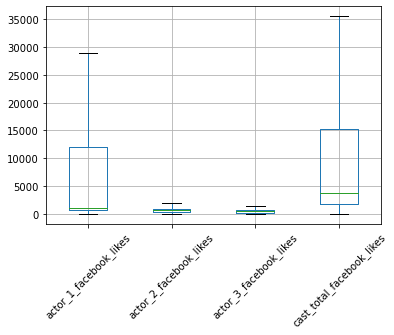

In [35]:
# boxplot showing facebook likes for actors
boxplot = movies_trimmed.boxplot(column=['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes'], rot=45)

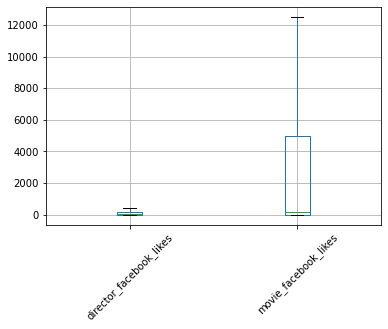

In [36]:
# boxplot showing facebook likes for directors and movies
boxplot = movies_trimmed.boxplot(column=['director_facebook_likes','movie_facebook_likes'], rot=45)

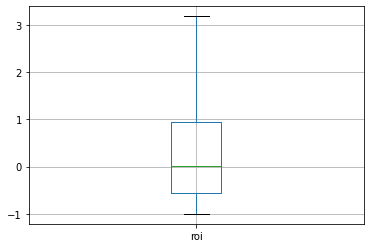

In [37]:
# boxplot showing roi
boxplot = movies_trimmed.boxplot(column=['roi'])

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


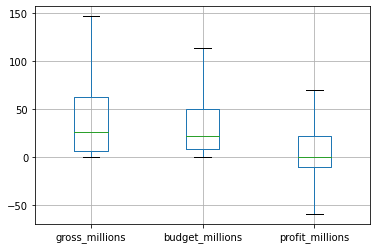

In [38]:
# boxplot showing financial variables
boxplot = movies_trimmed.boxplot(column=['gross_millions','budget_millions','profit_millions'])

In [39]:
mean_profit = movies['profit_millions'].mean()
mean_gross = movies['gross_millions'].mean()

### Explore Categorical Variables

In [40]:
movies['director_name'].value_counts()

Steven Spielberg        15
Woody Allen             15
Clint Eastwood          14
Steven Soderbergh       13
Ridley Scott            12
                        ..
Marc Levin               1
Michael Landon Jr.       1
Robert Fontaine          1
Eric Nicholas            1
Michael Patrick King     1
Name: director_name, Length: 1906, dtype: int64

In [41]:
movies['actor_1_name'].value_counts()

Robert De Niro     33
Matt Damon         28
J.K. Simmons       27
Nicolas Cage       27
Johnny Depp        25
                   ..
Richard Moll        1
Fann Wong           1
Danny Strong        1
Vanessa Lengies     1
Austin Nichols      1
Name: actor_1_name, Length: 1500, dtype: int64

In [42]:
movies['actor_2_name'].value_counts()

Morgan Freeman       13
Charlize Theron      13
Brad Pitt            10
Adam Sandler         10
James Franco          9
                     ..
Tim Daly              1
Aaron Kwok            1
Brit Morgan           1
Ari Gold              1
Dennis L.A. White     1
Name: actor_2_name, Length: 2227, dtype: int64

In [43]:
movies['actor_3_name'].value_counts()

Steve Coogan        8
Stephen Root        7
Bruce McGill        6
Steve Carell        6
Shawn Hatosy        6
                   ..
Richard E. Grant    1
Nikki Griffin       1
Samuel Roukin       1
Desmond Llewelyn    1
Austin Nichols      1
Name: actor_3_name, Length: 2615, dtype: int64

In [44]:
movies['plot_keywords'].value_counts()

# plot keywords will be more effectively analyzed by separating the keywords

based on novel                                                                 3
one word title                                                                 3
after dark horrorfest                                                          2
two word title                                                                 2
avatar|college|death|tron|university                                           1
                                                                              ..
college|drugs|patient|psychologist|secret                                      1
blood splatter|detention|high school|overalls|reference to c. thomas howell    1
birthday|falling through a glass roof|game|hitchcockian|suicide                1
50s|film within a film|hollywood|illegitimate pregnancy|twins                  1
flood|mammoth|no opening credits|squirrel|valley                               1
Name: plot_keywords, Length: 3514, dtype: int64

In [45]:
movies['country'].value_counts()

USA               2907
UK                 317
Canada              99
France              78
Germany             75
Australia           37
Spain               20
Ireland             12
New Zealand         10
South Africa         7
Italy                6
Denmark              6
South Korea          5
India                5
Hong Kong            5
China                4
Mexico               3
Japan                3
Belgium              2
Norway               2
Czech Republic       2
Romania              2
Thailand             2
New Line             1
Bahamas              1
Aruba                1
Philippines          1
Russia               1
Greece               1
Official site        1
Iceland              1
Hungary              1
Switzerland          1
Nigeria              1
Georgia              1
Slovakia             1
Cameroon             1
Bulgaria             1
Chile                1
Brazil               1
Poland               1
Kyrgyzstan           1
Panama               1
Cambodia   

In [46]:
movies['content_rating'].value_counts()

R            1598
PG-13        1223
PG            467
G              74
Not Rated      64
Unrated        26
NC-17           4
TV-PG           3
TV-G            3
TV-14           2
Name: content_rating, dtype: int64

In [47]:
movies['key_actors'] = movies['actor_1_name'].map(str) + '-' + movies['actor_2_name'].map(str) + '-' + movies['actor_3_name'].map(str)
movies['key_actors']

0               CCH Pounder-Joel David Moore-Wes Studi
1             Johnny Depp-Orlando Bloom-Jack Davenport
2        Christoph Waltz-Rory Kinnear-Stephanie Sigman
3        Tom Hardy-Christian Bale-Joseph Gordon-Levitt
4            Daryl Sabara-Samantha Morton-Polly Walker
                             ...                      
3626    Kerry Bishé-Caitlin FitzGerald-Daniella Pineda
3627            Eric Mabius-Daphne Zuniga-Crystal Lowe
3628          Eva Boehnke-Maxwell Moody-David Chandler
3629               Alan Ruck-Daniel Henney-Eliza Coupe
3630             John August-Brian Herzlinger-Jon Gunn
Name: key_actors, Length: 3631, dtype: object

### Explore Relationships in the Data

**Variables that are moderately correlated (correlation > 0.4) with gross revenue:** num_critic_reviews, num_users_voted, num_user_reviews, budget, profit_millions, roi, profit_margin 
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with profit:** gross_millions, num_users_voted, roi, profit_margin
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with profit margin:** gross_millions, roi, profit_margin
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with ROI:** gross_millions, profit_millions, profit_margin

In [48]:
corr_matrix_trimmed = movies_trimmed.corr()
corr_matrix_trimmed.to_csv('corr_matrix_trimmed.csv')

corr_matrix_trimmed

,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_users_voted,cast_total_facebook_likes,num_user_reviews,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,budget_millions,gross_millions,profit_millions,roi,profit_margin
num_critic_reviews,1.000000,0.394289,0.301181,0.268481,0.354494,0.488449,0.767494,0.370048,0.701138,0.454179,0.315778,0.318822,0.427926,0.224160,0.658916,0.454179,0.488449,0.243002,0.214949,0.295355
duration,0.394289,1.000000,0.297912,0.228265,0.283452,0.300564,0.439145,0.296022,0.461759,0.399573,-0.047786,0.256024,0.378546,0.265530,0.275274,0.399573,0.300564,0.038622,-0.029660,0.052817
director_facebook_likes,0.301181,0.297912,1.000000,0.125384,0.199145,0.174941,0.312317,0.199772,0.302551,0.229678,-0.033751,0.155277,0.222228,0.106776,0.189447,0.229678,0.174941,0.025408,0.022295,0.067312
actor_3_facebook_likes,0.268481,0.228265,0.125384,1.000000,0.479158,0.322661,0.315646,0.619941,0.272083,0.327581,0.006159,0.786824,0.061721,0.092626,0.185486,0.327581,0.322661,0.142608,0.046355,0.152088
actor_1_facebook_likes,0.354494,0.283452,0.199145,0.479158,1.000000,0.250702,0.401760,0.957450,0.313532,0.311591,0.048491,0.591973,0.221685,0.155500,0.259046,0.311591,0.250702,0.056227,0.009701,0.092336
gross,0.488449,0.300564,0.174941,0.322661,0.250702,1.000000,0.690126,0.290694,0.573019,0.700651,0.080818,0.329247,0.192612,0.126180,0.298114,0.700651,1.000000,0.640619,0.427922,0.527961
num_users_voted,0.767494,0.439145,0.312317,0.315646,0.401760,0.690126,1.000000,0.419525,0.841718,0.552155,0.020237,0.367225,0.477585,0.175432,0.535428,0.552155,0.690126,0.415107,0.303764,0.390671
cast_total_facebook_likes,0.370048,0.296022,0.199772,0.619941,0.957450,0.290694,0.419525,1.000000,0.329231,0.343167,0.054140,0.735610,0.207834,0.152439,0.274626,0.343167,0.290695,0.082020,0.020069,0.110551
num_user_reviews,0.701138,0.461759,0.302551,0.272083,0.313532,0.573019,0.841718,0.329231,1.000000,0.495204,-0.140842,0.299983,0.384821,0.159724,0.387019,0.495204,0.573019,0.313815,0.268043,0.355777
budget,0.454179,0.399573,0.229678,0.327581,0.311591,0.700651,0.552155,0.343167,0.495204,1.000000,-0.016055,0.356489,0.127242,0.215136,0.242201,1.000000,0.700651,-0.039952,-0.138542,0.122853


## Actor Analysis
<br>
Do certain actors tend to make more successful movies?

In [57]:
# concatenate actor1, actor2, and actor3 columns to create df with all actors
actor1_names = movies[['actor_1_name']]
actor1_names = actor1_names.rename(columns={"actor_1_name": "names"})

actor2_names = movies[['actor_2_name']]
actor2_names = actor2_names.rename(columns={"actor_2_name": "names"})

actor3_names = movies[['actor_3_name']]
actor3_names = actor3_names.rename(columns={"actor_3_name": "names"})

actor_names = pd.concat([actor1_names, actor2_names, actor3_names])

# calculate number of movies per actor
actor_counts = actor_names['names'].value_counts()

# create a list that contains all actors who have appeared in at least 4 movies
actor_counts_lst = actor_counts[actor_counts >= 4].index.tolist()

# concatenate actor2, and actor3 columns to create df with all supporting actors
actor_supporting_names = pd.concat([actor2_names, actor3_names])

# calculate number of movies per actor
actor_supporting_counts = actor_supporting_names['names'].value_counts()

# create a list that contains all actors who have appeared in at least 4 movies
actor_supporting_lst = actor_supporting_counts[actor_supporting_counts >= 4].index.tolist()

### Profit per actor, as a percentage of average profit
Calculating profit per actor, as a percentage of average profit normalizes the profit metric and allows for analysis of how each actor's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only actors who have appeared in at least 4 movies; (2) calculate average profit per actor; (3) divide average profit per actor by overall average profit for all movies.
<br>
<br>
**Result**: There are 48 main actors (actor1) and 205 supporting actors (actor2 or actor3) with an average profit, as a pct. of overall average greater than 2 - indicating that the movies these actors appear in have an average profit that is at least 100% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

#### Lead Actor

In [58]:
# actor1 - actors who have been the lead actor in at least 4 movies
# calculate number of movies per actor
actor1_counts = movies['actor_1_name'].value_counts()

# create a list that contains all actors who have appeared in at least 4 movies
actor1_list = actor1_counts[actor1_counts >= 4].index.tolist()

# filter movies df to show only actors who have appeared in at least 4 movies
actors1 = movies[movies['actor_1_name'].isin(actor1_list)]

# groupby actor; calculate average profit per actor
actor1_total = actors1.groupby(['actor_1_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor1_total['profit_pct_mean'] = (actor1_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor1_profit_pct_mean = actor1_total[actor1_total['profit_pct_mean'] > 2]

actor1_profit_count = actor1_profit_pct_mean.count()
actor1_profit_count

actor_1_name       48
profit_millions    48
profit_pct_mean    48
dtype: int64

#### Supporting Actors

In [59]:
# actor 2
# filter movies df to show only actors who have appeared as a supporting actor (either actor2 or actor3) in at least 4 movies
actors2 = movies[movies['actor_2_name'].isin(actor_supporting_lst)]

# groupby actor; calculate average profit per actor
actor2_total = actors2.groupby(['actor_2_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor2_total['profit_pct_mean'] = (actor2_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor2_profit_pct_mean = actor2_total[actor2_total['profit_pct_mean'] > 2]

actor2_profit_count = actor2_profit_pct_mean.count()

In [60]:
# actor3
# filter movies df to show only actors who have appeared as a supporting actor (either actor2 or actor3) in at least 4 movies
actors3 = movies[movies['actor_3_name'].isin(actor_supporting_lst)]

# groupby actor; calculate average profit per actor
actor3_total = actors3.groupby(['actor_3_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor3_total['profit_pct_mean'] = (actor3_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor3_profit_pct_mean = actor3_total[actor3_total['profit_pct_mean'] > 2]

actor3_profit_count = actor3_profit_pct_mean.count()

In [61]:
# concatenate actor2 column from actor2_profit_pct_mean and actor3 column from actor3_profit_pct_mean
actor2 = actor2_profit_pct_mean[['actor_2_name']]
actor2 = actor2.rename(columns={"actor_2_name": "names"})

actor3 = actor3_profit_pct_mean[['actor_3_name']]
actor3 = actor3.rename(columns={"actor_3_name": "names"})

actors_supporting = pd.concat([actor2, actor3])

# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
actors_supporting = actors_supporting.drop_duplicates()

actors_supporting_count = actors_supporting.count()
actors_supporting_count

names    205
dtype: int64

### ROI per actor, as a percentage of average ROI
Calculating ROI per actor, as a percentage of average ROI normalizes the ROI metric and allows for analysis of how each actor's average ROI compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only actors who have appeared in at least 4 movies; (2) calculate average ROI per actor; (3) divide average ROI per actor by overall average ROI for all actors.
<br>
<br>
**Result**: There are 31 main actors (actor1) and 205 supporting actors (actor2 or actor3) with an average ROI, as a pct. of overall average greater than 1.5 - indicating that the movies these actors act in have an average roi that is at least 50% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

#### Lead Actor

In [62]:
# actor1
# groupby actor; calculate average roi per actor
actor1_roi = actors1.groupby(['actor_1_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor1_roi['roi_pct_mean'] = (actor1_roi['roi']/ movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor1_roi_pct_mean = actor1_roi[actor1_roi['roi'] >= 1.5]

actor1_roi_count = actor1_roi_pct_mean.count()
actor1_roi_count

actor_1_name    31
roi             31
roi_pct_mean    31
dtype: int64

#### Supporting Actors

In [63]:
# actor2
# groupby actor; calculate average roi per actor
actor2_roi = actors2.groupby(['actor_2_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor2_roi['roi_pct_mean'] = (actor2_roi['roi']/movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor2_roi_pct_mean = actor2_roi[actor2_roi['roi'] >= 1.5]

actor2_roi_count = actor2_roi_pct_mean.count()

In [64]:
# actor3
# groupby actor; calculate average roi per actor
actor3_roi = actors3.groupby(['actor_3_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor3_roi['roi_pct_mean'] = (actor3_roi['roi']/movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor3_roi_pct_mean = actor3_roi[actor3_roi['roi'] >= 1.5]

actor3_roi_count = actor3_roi_pct_mean.count()

In [65]:
# concatenate actor2 column from actor2_profit_pct_mean and actor3 column from actor3_profit_pct_mean
actor2 = actor2_roi_pct_mean[['actor_2_name']]
actor2 = actor2.rename(columns={"actor_2_name": "names"})

actor3 = actor3_roi_pct_mean[['actor_3_name']]
actor3 = actor3.rename(columns={"actor_3_name": "names"})

actors_supporting = pd.concat([actor2, actor3])

# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
actors_supporting = actors_supporting.drop_duplicates()

actors_supporting_count = actors_supporting.count()
actors_supporting_count

names    105
dtype: int64

## Analyze director success

Do certain director's tend to make more successful movies?

### Profit per director, as a percentage of average profit
Calculating profit per director, as a percentage of average profit normalizes the profit metric and allows for analysis of how each director's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only directors who have directed at least 5 movies; (2) calculate average profit per director; (3) divide average profit per actor by overall average profit for all directors.
<br>
<br>
**Result**: There are 59 directors with average profit, as a pct. of overall average greater than 2 - indicating that the movies these directors direct have an average profit that is at least 100% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [66]:
#calculating profit as a pct. of average profit for directors
director_counts = movies['director_name'].value_counts()

#creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= 5].index.tolist()

#creating a dataframe with actors in 5 or more movies
director = movies[movies['director_name'].isin(director_list)]

#creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['profit_millions'].mean().sort_values (by='profit_millions', ascending=False)

#creating the profit_pct_mean value feature
director_total['profit_pct_mean'] = (director_total['profit_millions']/ movies['profit_millions'].mean())
director_profit_pct_mean = director_total[director_total['profit_pct_mean'] > 2] 

director_profit_pct_mean_count = director_profit_pct_mean.count()
director_profit_pct_mean_count

director_name      59
profit_millions    59
profit_pct_mean    59
dtype: int64

### ROI per director, as a percentage of average ROI
Calculating ROI per director, as a percentage of average ROI normalizes the ROI metric and allows for analysis of how each director's average ROI compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only directors who have directed at least 5 movies; (2) calculate average ROI per director; (3) divide average ROI per actor by overall average profit for all directors.
<br>
<br>
**Result**: There are 4 directors with average ROI, as a pct. of overall average greater than 1.5 - indicating that the movies these directors direct have an average ROI that is at least 50% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average ROI, and should be hired on future movies.

In [67]:
#calculating profit as a pct. of average profit for directors
director_counts = movies['director_name'].value_counts()

#creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= 5].index.tolist()

#creating a dataframe with actors in 5 or more movies
director = movies[movies['director_name'].isin(director_list)]

#creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['roi'].mean().sort_values (by='roi', ascending=False)

#creating the profit_pct_mean value feature
director_total['roi_pct_mean'] = (director_total['roi']/ movies['roi'].mean())
director_roi_pct_mean = director_total[director_total['roi_pct_mean'] > 1.5] 

director_roi_pct_mean_count = director_roi_pct_mean.count()
director_roi_pct_mean_count

director_name    4
roi              4
roi_pct_mean     4
dtype: int64

### Summary outcomes by director

**Method**: Analyze summary outcomes by director.
<br>
<br>
**Result**: Several of the top directors by revenue and profit have only directed one or two movies and therefore will not be included in the profit per director analysis. This indicates while the studio should aim to work with high-VAR directors in order to seek out consistent profit, up-and-coming directors should not be ignored. Further analysis is needed to determine determinants of success for up-and-coming directors.

In [68]:
#group by director; calculate average of relevant variables
directors_mean = movies[['director_name','gross_millions','profit_millions','budget_millions','roi','movie_score','director_facebook_likes','movie_facebook_likes']].groupby(['director_name']).mean()

In [69]:
#group by director; count number of movies
directors_count = movies[['director_name','color']].groupby(['director_name']).count().sort_values(by='color',ascending = False)
directors_count = directors_count.rename(columns = {'color': 'num_movies'})

In [70]:
# merge director data into one df
directors_df_lst = [directors_mean, directors_count]
directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)
directors_df = directors_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi',
                                             'movie_score': 'avg_movie_score',
                                             'director_facebook_likes':'avg_director_fb_likes',
                                             'movie_facebook_likes':'avg_movie_fb_likes'})

directors_df['avg_movie_score'] = round(directors_df['avg_movie_score'],2)
directors_df['avg_movie_fb_likes'] = round(directors_df['avg_movie_fb_likes'],2)
directors_df.to_csv('directors_df.csv')

In [71]:
# directors with top average movie scores
directors_df.sort_values(by = 'avg_profit_millions', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
director_name,,,,,,,,
James Cameron,709.58905,491.089050,218.500000,2.251150,7.80,0.0,29500.00,2
Tim Miller,363.02430,305.024300,58.000000,5.259000,8.10,84.0,117000.00,1
George Lucas,388.49430,274.160967,114.333333,2.397733,6.93,0.0,7666.67,3
Kyle Balda,336.02960,262.029600,74.000000,3.540900,6.40,22.0,70000.00,1
Colin Trevorrow,328.09255,252.717550,75.375000,3.845750,7.00,365.0,90500.00,2
Chris Buck,400.73660,250.736600,150.000000,1.671600,7.60,69.0,58000.00,1
Yarrow Cheney,323.50550,248.505500,75.000000,3.313400,6.80,11.0,36000.00,1
Pierre Coffin,309.77560,237.275600,72.500000,3.243900,7.60,275.0,43500.00,2
Lee Unkrich,414.98450,214.984500,200.000000,1.074900,8.30,125.0,30000.00,1


In [72]:
# directors who directed the largest number of movies
directors_df.sort_values(by = 'num_movies', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
director_name,,,,,,,,
Woody Allen,15.347033,-1.552967,16.900000,0.033160,6.89,11000.0,10658.60,15
Steven Spielberg,133.659013,45.259013,88.400000,0.661140,7.27,14000.0,19600.00,15
Clint Eastwood,78.882093,30.896379,47.985714,0.834993,7.14,16000.0,18050.36,14
Steven Soderbergh,73.975315,29.206085,44.769231,1.462954,6.61,0.0,7510.54,13
Ridley Scott,88.017692,-2.065642,90.083333,-0.085708,7.06,0.0,27825.92,12
Robert Rodriguez,51.147064,18.056155,33.090909,0.630409,5.45,0.0,5599.09,11
Ron Howard,101.910945,18.092764,83.818182,0.152782,6.94,2000.0,12785.55,11
Bobby Farrelly,62.790950,24.064589,40.777778,1.007767,6.13,101.0,8300.00,10
Kevin Smith,25.033037,8.001788,14.525000,6.642188,6.38,0.0,4600.00,10


## Analzye Genre Success

**Method**: Analyze summary outcomes by genre. Movies can be classified under more than one genre; for this analysis, any movies that is classified under a genre is included in that genre's analysis. For example - a movie whose genres are "romance" and "comedy" will be included in the analyses for both genres.

In [73]:
movies['genres'].value_counts()

Comedy                                  169
Drama                                   164
Comedy|Drama                            154
Comedy|Drama|Romance                    148
Comedy|Romance                          139
                                       ... 
Crime|Documentary|Drama                   1
Crime|Romance|Thriller                    1
Action|Fantasy|Western                    1
Comedy|Family|Music                       1
Crime|Drama|Mystery|Thriller|Western      1
Name: genres, Length: 731, dtype: int64

In [74]:
# add binary genre variable to movies df

#create list of genres
genre_lst = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Music','Mystery','Thriller','Horror','Romance','Sci-Fi']

# create column for each genre in genre_lst
for x in genre_lst:
    movies['genre_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies['genres'])):
    for y in genre_lst:
        if y in movies['genres'][x]:
            movies['genre_' + y.lower()][x] = y.lower()
        else:
            movies['genre_' + y.lower()][x] = 'not ' + y.lower()

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Create df to analyze average outcome by genre

In [75]:
genre_avg = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).mean()
    x = x.rename_axis('genre', axis= 0)
    genre_avg = genre_avg.append(x)

genre_avg = genre_avg[genre_avg.index.str.contains("not")==False]

#### barplot - average gross by genre

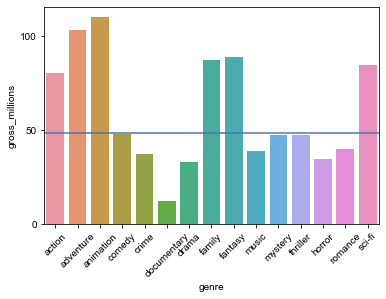

In [76]:
genre_avg_gross = sns.barplot(x= genre_avg.index, y="gross_millions", data=genre_avg)
genre_avg_gross.set_xticklabels(genre_avg_gross.get_xticklabels(),rotation=45)
genre_avg_gross.axhline(mean_gross)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)

#plt.savefig('genre_avg_gross.png')

#### barplot - average profit by genre

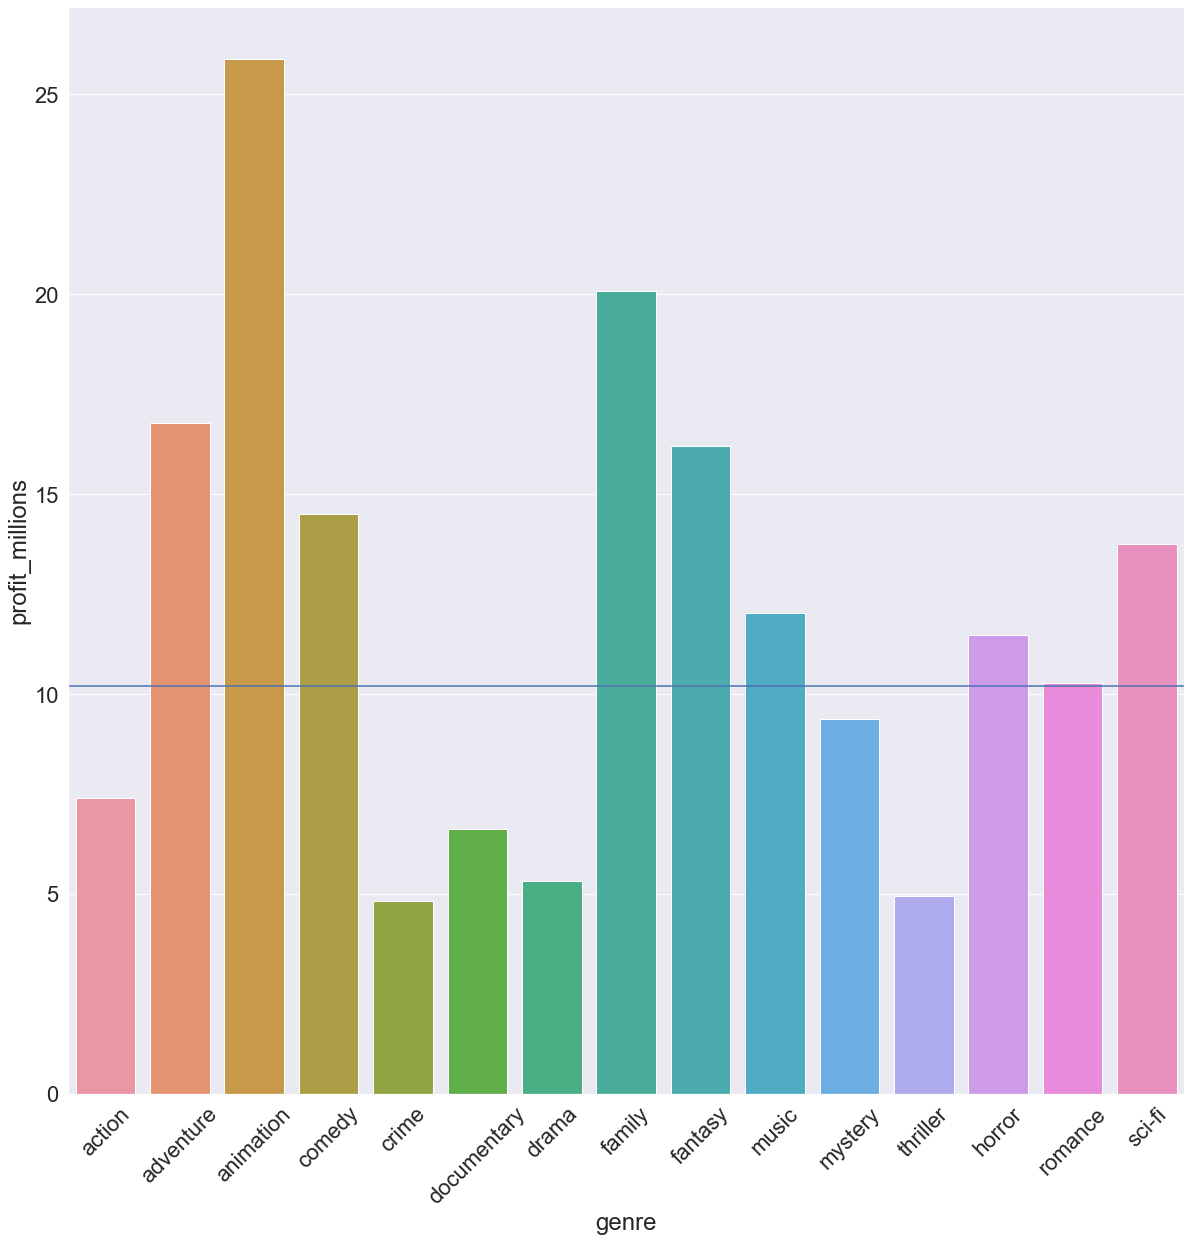

In [86]:
genre_avg_profit = sns.barplot(x= genre_avg.index, y="profit_millions", data=genre_avg)
genre_avg_profit.set_xticklabels(genre_avg_profit.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)
genre_avg_profit.axhline(mean_profit)

#plt.savefig('genre_avg_profit.png')

### Create df to analyze total outcome (sum) by genre

In [87]:
genre_sum = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).sum()
    x = x.rename_axis('genre', axis= 0)
    genre_sum = genre_sum.append(x)

genre_sum = genre_sum[genre_sum.index.str.contains("not")==False]


#### barplot - total gross by genre

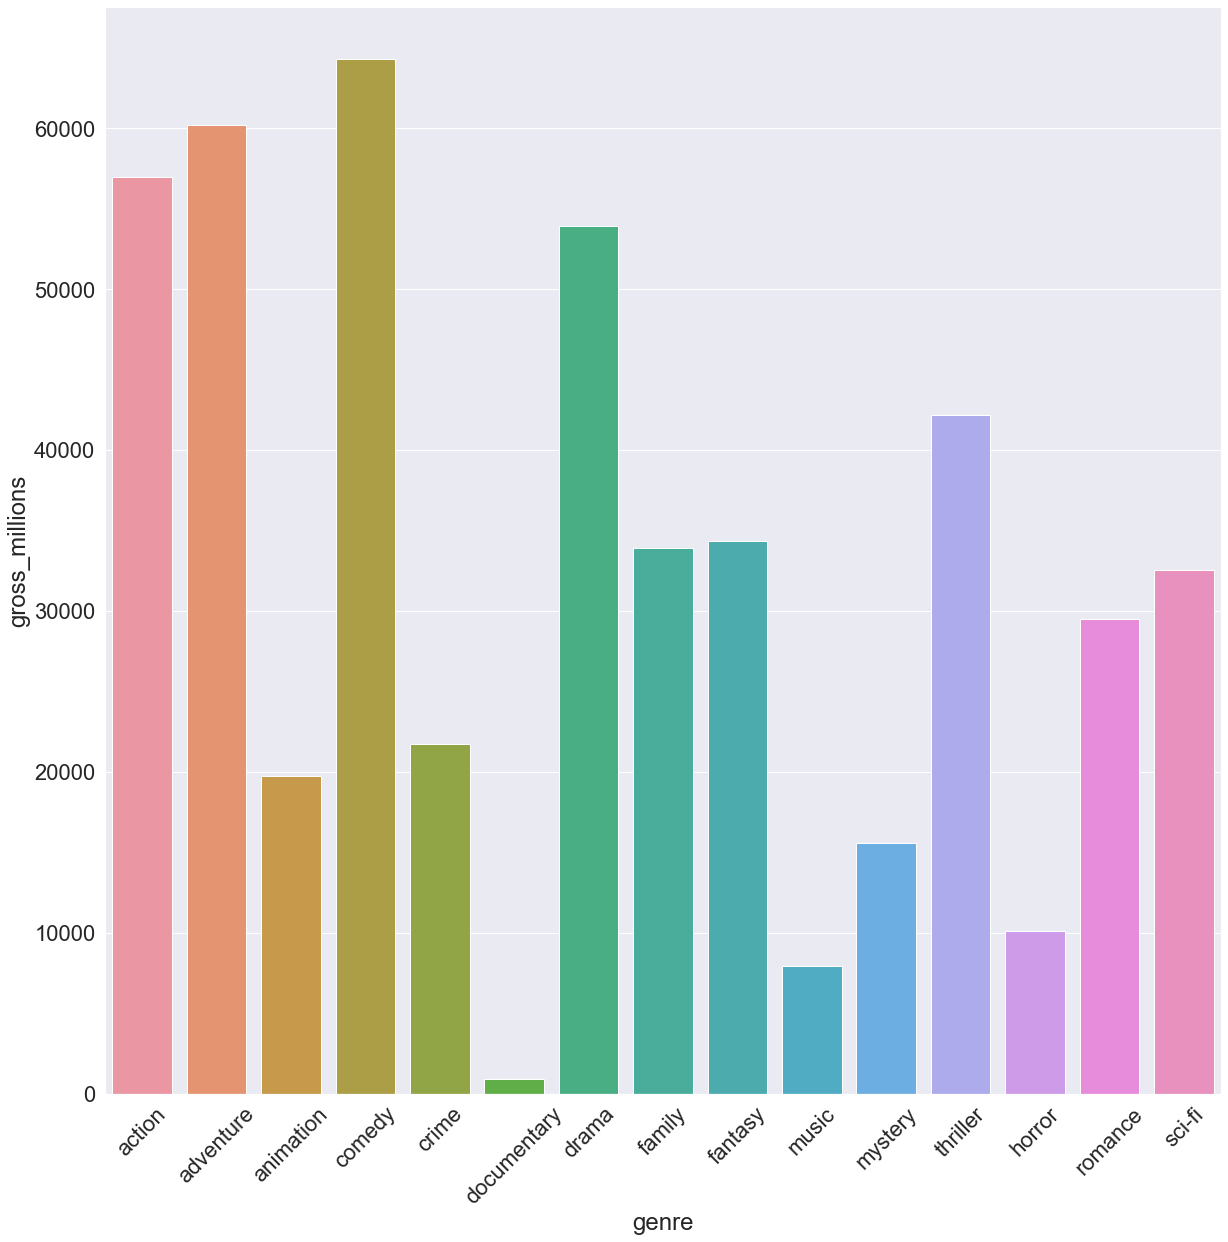

In [88]:
genre_sum_gross = sns.barplot(x= genre_sum.index, y="gross_millions", data=genre_sum)
genre_sum_gross.set_xticklabels(genre_sum_gross.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)

#plt.savefig('genre_sum_gross.png')

#### barplot - total profit by genre

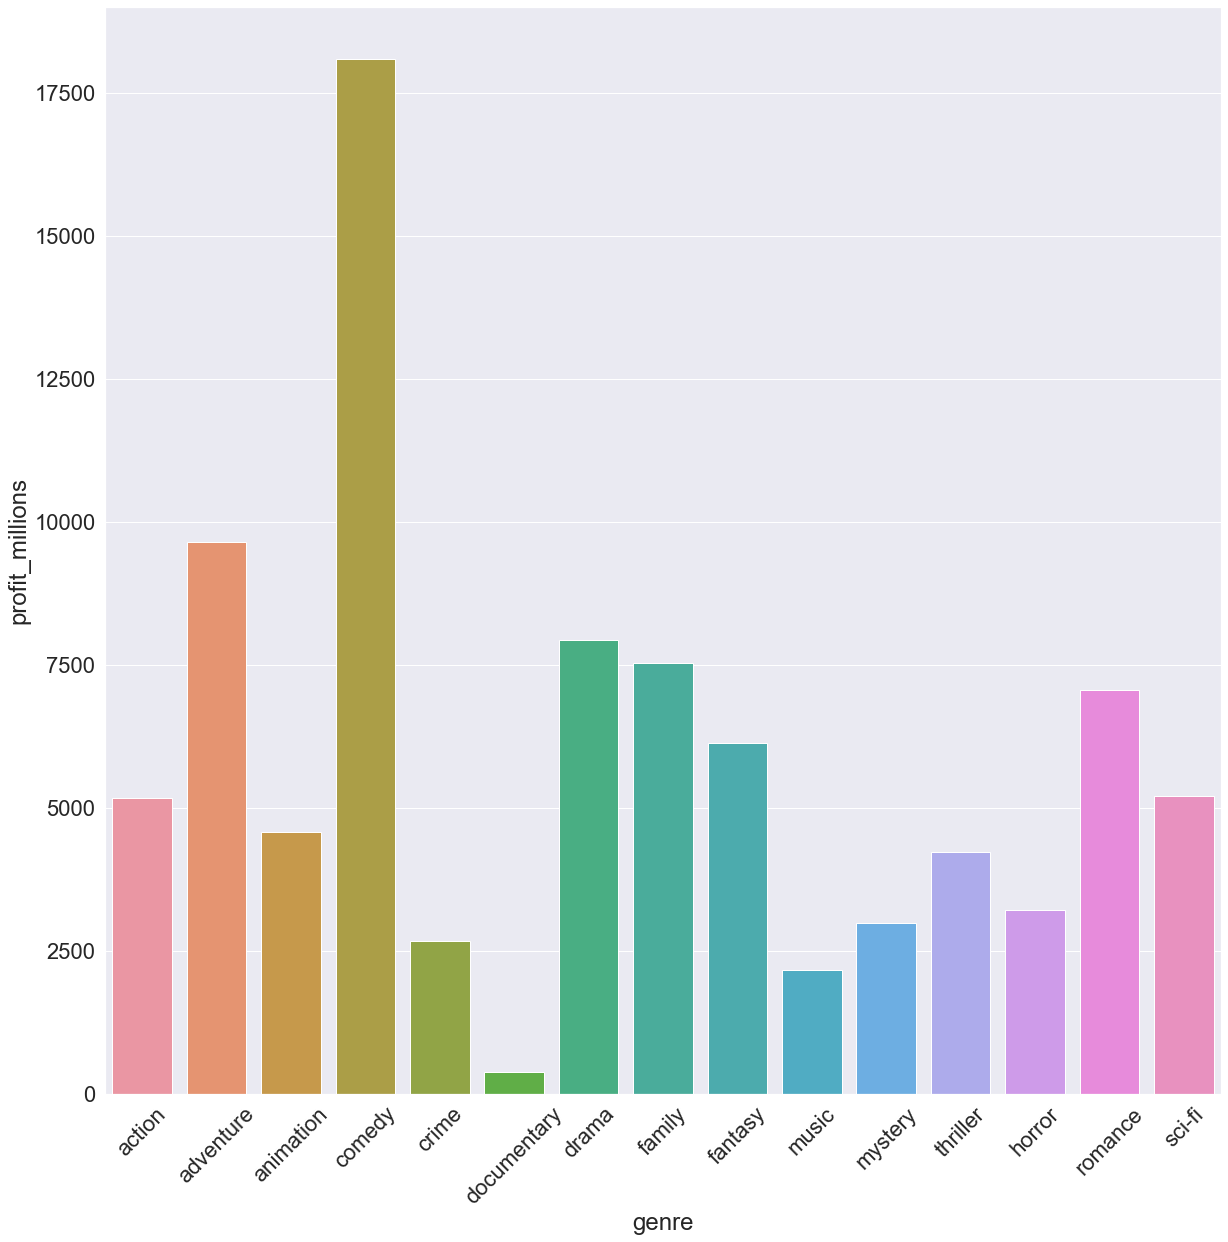

In [89]:
genre_sum_revenue = sns.barplot(x= genre_sum.index, y="profit_millions", data=genre_sum)
genre_sum_revenue.set_xticklabels(genre_sum_revenue.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

#plt.savefig('genre_sum_profit.png')

### Create df to analyze count by genre

In [90]:
genre_count = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).count()
    x = x.rename_axis('genre', axis= 0)
    genre_count = genre_count.append(x)

genre_count = genre_count[genre_count.index.str.contains("not")==False]
genre_count['pct_total']= genre_count['color'] / genre_count['color'].sum()

genre_count = genre_count[['color','pct_total']].copy()
genre_count.rename(columns={"color": "count"})

,count,pct_total
genre,,
action,791,0.081404
adventure,615,0.063291
animation,194,0.019965
comedy,1460,0.150252
crime,640,0.065864
documentary,103,0.010600
drama,1813,0.186580
family,419,0.043120
fantasy,418,0.043017


## Keyword Analysis

Analyze which keywords are associated with stronger outcomes.
<br>
<br>
**Method**: (1) filter df to show only keywords that are associated with at least 30 movies; (2) calculate average outcomes per keyword.
<br>
<br>
**Result**: There are 44 keywords with an average profit greater than 2, and/or an average ROI greater than 1.5. These topics have a track record of strong outcomes. Therefore, future movies should focus their plots on these topics.

In [139]:
# create list of plot keywords
movies['plot_keywords'] = movies['plot_keywords'].astype(str)
lst = movies['plot_keywords'].tolist()

# define empty list
lst_keywords = []

# split keywords on |; append keywords to lst_keywords
for i in lst:
    lst_keywords.append(i.split('|'))

# define function to flatten list of lists into one list (function pulled from stack overflow: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists)
def flatten(t):
    return [item for sublist in t for item in sublist]

# apply flatten() to lst_keywords to create list of all keywords
keywords = pd.DataFrame(flatten(lst_keywords),columns=['keywords'])

In [140]:
#calculate value counts for each keyword
keyword_counts = keywords['keywords'].value_counts()

#create a list of keywords that are associated with at least 50 movies
keyword_lst = keyword_counts[keyword_counts >= 30].index.tolist()

#create a dataframe with keywords associated with 50 or more movies
keyword = movies[movies['plot_keywords'].isin(keyword_list)]

In [141]:
# add binary keyword variable to movies df
movies_kw = movies

# create column for each genre in genre_lst
for x in keyword_lst:
    movies_kw['keyword_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies_kw['plot_keywords'])):
    for y in keyword_lst:
        if y in movies_kw['plot_keywords'][x]:
            movies_kw['keyword_' + y.lower()][x] = y.lower()
        else:
            movies_kw['keyword_' + y.lower()][x] = 'not ' + y.lower()

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


### Create df to analyze average outcome by keyword

In [142]:
kw_avg = pd.DataFrame()
for x in keyword_lst:
    x = movies.groupby(['keyword_' + x.lower()]).mean()
    x = x.rename_axis('keyword', axis= 0)
    kw_avg = kw_avg.append(x)

kw_avg = kw_avg[kw_avg.index.str.contains("not")==False]

In [143]:
top_keywords_profit = kw_avg[kw_avg['profit_millions'] > 2]

top_keywords_profit_lst = top_keywords_profit.index.tolist()

In [144]:
top_keywords_roi = kw_avg[kw_avg['roi'] > 1.5]

top_keywords_roi_lst = top_keywords_roi.index.tolist()

In [145]:
top_keywords = pd.concat([top_keywords_profit, top_keywords_roi])

# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
top_keywords = top_keywords.drop_duplicates()

keywords_count = keywords.count()

# Ideas for additional analysis

How successful are sequels and series'?
<br>
Closer look at popular groupings of genres (i.e. romance and comedy; action and adventure)
<br>
Analysis of whether or not facebook likes predict actor success
<br>
Analysis of outcomes by content rating